# Applied Machine Learning
## Train your first machine learning model
- Author: Lorien Pratt
- Copyright: Quantellia LLC 2019.  All Rights Reserved

## Setup

In [15]:
my_initials<-"jing" # Set your initials to use for model and data files

##### Install and initialize the H2O library, which we will use to do the grid search
Note that this will generate a lot of warnings. These are expected, and not errors but rather notifications

In [16]:
require(h2o)
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         25 minutes 55 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.26.0.10 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_jupyter_ldd243 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.34 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.1 (2019-07-05) 



Install a number of R packages we'll need to display the results

In [18]:
# This will generate what look like warnings, but are really notifications
# uncomment install.packages if you are on a new instance without these packages pre-installed
#install.packages("plyr")
#install.packages("pROC")
#install.packages("SDMTools")
#install.packages("RColorBrewer")
install.packages("ggplot")
require(plyr)
require(pROC)
require(SDMTools)
require(RColorBrewer)
require(ggplot)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)
Warning message:
“package ‘ggplot’ is not available (for R version 3.6.1)”Loading required package: ggplot
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ggplot’”

Create the file names from your initials, just as we did when building the files in the first place

In [21]:
train_filename<-paste0("/home/jupyter/Applied ML course/Lab 2 Iris/data/",my_initials,"_train_iris.csv"); print( train_filename )
test_filename<-paste0("/home/jupyter/Applied ML course/Lab 2 Iris/data/",my_initials,"_test_iris.csv"); print( test_filename )
backtest_filename<-paste0("/home/jupyter/Applied ML course/Lab 2 Iris/data/",my_initials,"_backtest_iris.csv"); print( backtest_filename )

[1] "/home/jupyter/Applied ML course/Lab 2 Iris/data/jing_train_iris.csv"
[1] "/home/jupyter/Applied ML course/Lab 2 Iris/data/jing_test_iris.csv"
[1] "/home/jupyter/Applied ML course/Lab 2 Iris/data/jing_backtest_iris.csv"


Read in the test and training files you created in the previous step. Convert them to h2o files along the way.

In [22]:
train_hex <- h2o.importFile(train_filename, parse = TRUE, header = TRUE, 
                            sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)
test_hex <- h2o.importFile(test_filename, parse = TRUE, header = TRUE, 
                           sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)
backtest_hex <- h2o.importFile(backtest_filename, parse = TRUE, header = TRUE, 
                           sep = "", col.names = NULL, col.types = NULL, na.strings = NULL)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


Set a number of configuration parameters for model training

In [23]:
config_epochs=10000
config_hidden=c(5)
config_input_dropout_ratio = 0.0
config_l1=1.0E-5
config_l2=0.001

**Tell the model training which of the columns are predictors.**
First, let's looK at the top of the dataset again to remind us of the structure...

In [24]:
head(train_hex)

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.4,3.2,5.3,2.3,0
5.5,2.4,3.7,1.0,0
5.0,3.4,1.5,0.2,1
5.5,2.4,3.8,1.1,0
6.0,2.9,4.5,1.5,0
6.4,2.9,4.3,1.3,0


Set the predictor columns and check that they're the right ones

In [25]:
predictors <- c(1,2,3,4)
names(train_hex)[predictors]

[1] "sepal_length" "sepal_width"  "petal_length" "petal_width"

Tell the model training which of the columns is the target column (in this case, the very last column, mpg)

In [26]:
targetcol<-ncol(train_hex)
names(train_hex)[targetcol]

[1] "class"

Train the model

In [27]:
model  <- h2o.deeplearning(
    x = predictors,
    y = targetcol,
    variable_importances=TRUE,
    model_id='model_1',
    training_frame=train_hex,
    validation_frame = test_hex,
    quiet_mode=FALSE,
    export_weights_and_biases=TRUE,
    activation="Tanh",              # Linear outputs
    autoencoder=FALSE,
    ignore_const_cols=F,
    train_samples_per_iteration=0,
    stopping_tolerance = 1e-5,
    classification_stop = -1,       # Disable irismatic stopping
    adaptive_rate=F,                # Manaully tuned learning rate
    reproducible=T,
    epochs=config_epochs,
    hidden=config_hidden,
    input_dropout_ratio = config_input_dropout_ratio, 
    l1=config_l1,
    l2=config_l2
  )

  |======================================================================| 100%


##### Plot how the error changed for the train and test set during learning. H2O calls the test set "Validation".

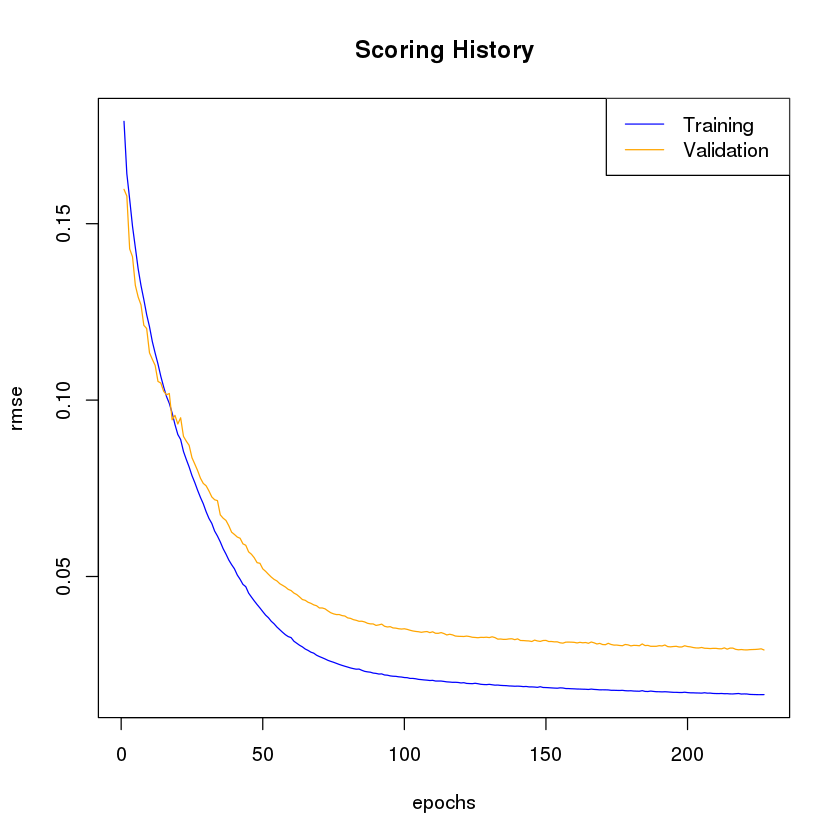

In [28]:
plot(model, timestep="epochs", metric="RMSE")

## Model evalution

Generate predictions for every row in the backtest set, and create two vectors: one with the truth and one with the prediction

In [29]:
predictions <- h2o.predict(model, backtest_hex)
#actual_column <- as.logical(as.vector(as.numeric(backtest_hex[ ,ncol(backtest_hex)])))
actual_column <- as.vector(as.numeric(backtest_hex[targetcol]))
predict_column <- as.vector(predictions[ ,'predict'])
str(actual_column)
str(predict_column)

  |======================================================================| 100%
 int [1:50] 0 0 0 0 1 0 0 0 1 0 ...
 num [1:50] 0.01121 -0.00718 -0.01863 -0.03531 0.99845 ...


Plot actuals versus predictions to get a visual sense of how well the model did

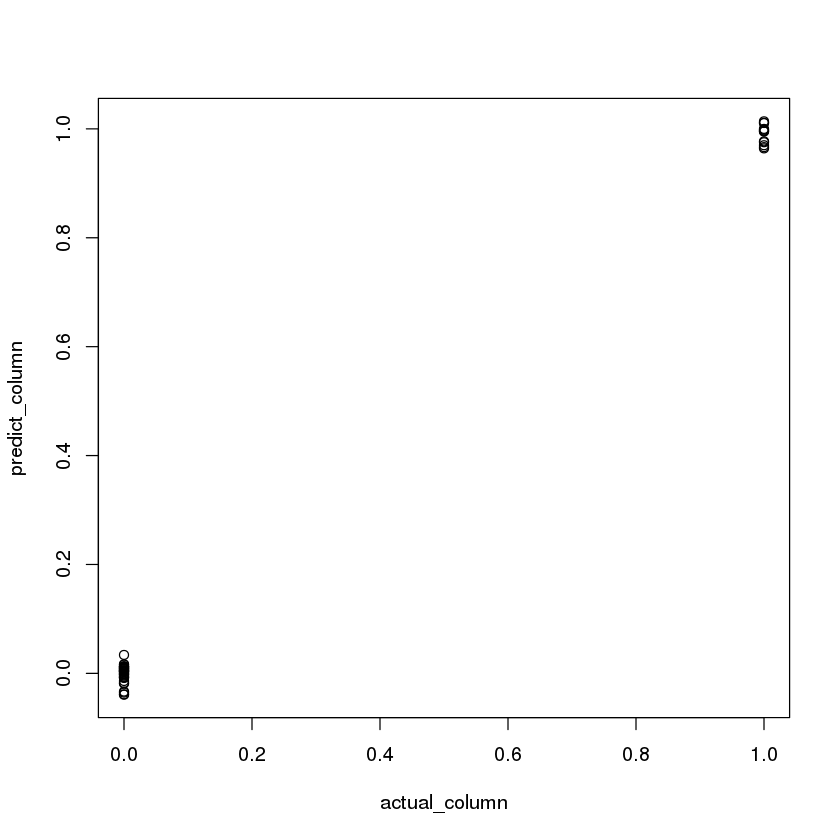

In [30]:
plot(actual_column,predict_column)

Extract the variable importances from the model and show them in a graph from most important to least important

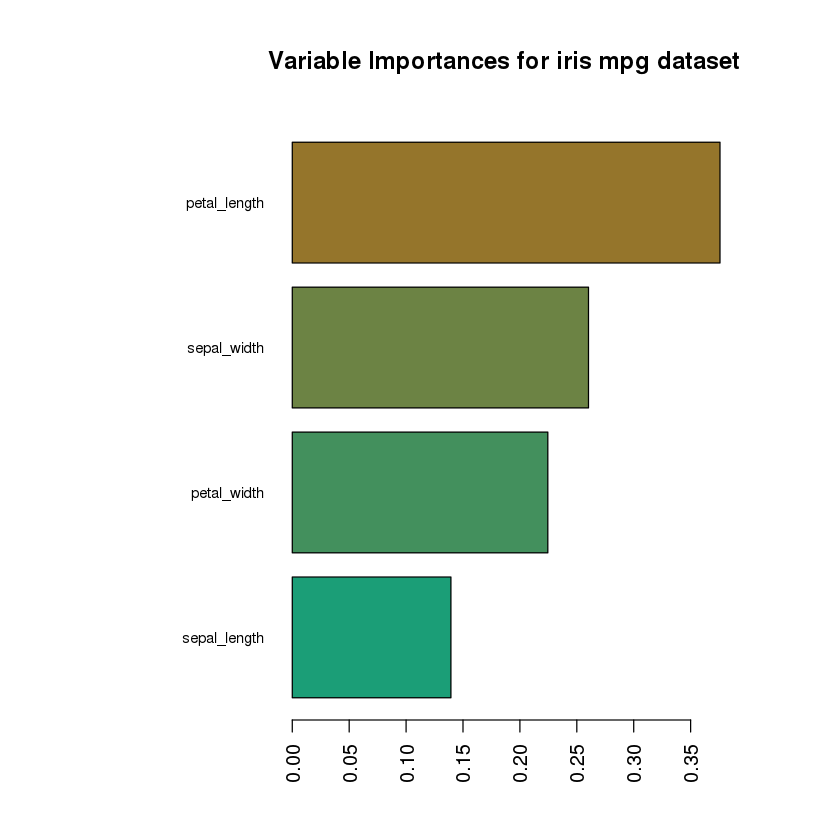

In [31]:
x<-model@model
vi<-x$variable_importances
par(mar=c(5, 12, 5, 5))
plotSize<-15
cols <- colorRampPalette(brewer.pal(4,"Dark2"))(plotSize)
barplot(rev(vi$percentage),las=2,main="Variable Importances for iris mpg dataset",
                    names.arg=rev(vi$variable),
                    horiz=TRUE,cex.names=0.75,col=cols)

###### 11. Create the ROC graph along with its AUC (to be used later when we do a classification model)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


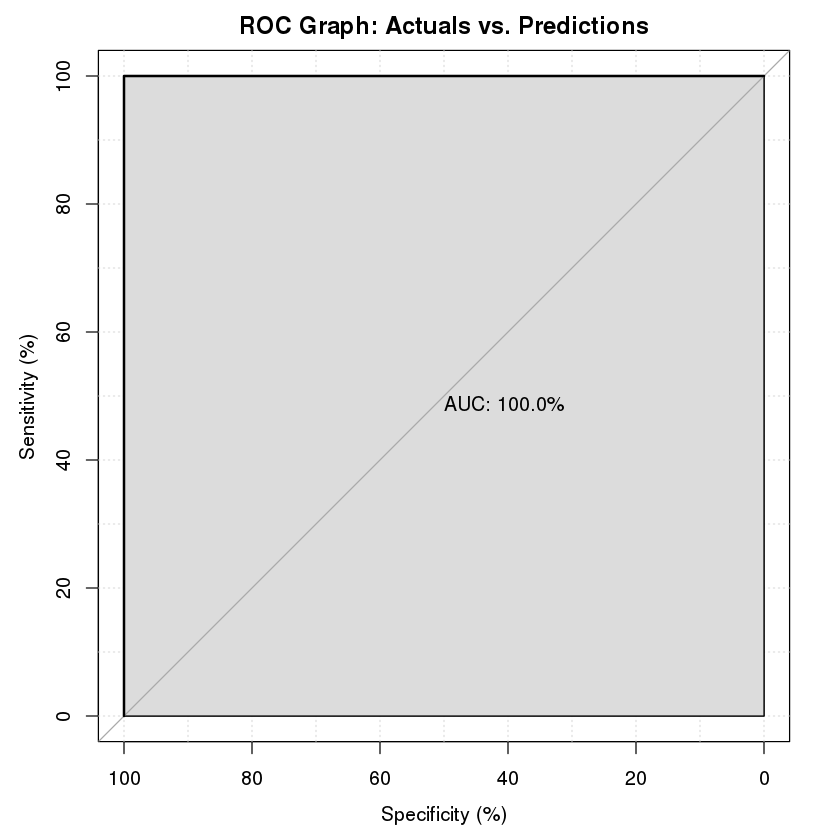

In [32]:
# Note this is a regression, not a classification problem, so ROC doesn't make sense
# Saving the code here so you can use this for a classification model later
# 
rocp1 <- roc(actual_column, predict_column,
        percent=TRUE,
        plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
        print.auc=TRUE, show.thres=TRUE, main="ROC Graph: Actuals vs. Predictions")

##### Save your trained model. We'll use it later for inference. 
Note that your initials appear in the **folder** name, not the model name.

In [33]:
#START HERE
model_filename<-paste0("models/",my_initials,"_iris_model")
h2o.saveModel(model, model_filename, force=T)

[1] "/home/jupyter/Applied ML course/models/jing_iris_model/model_1"